# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [15]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.random.seed(100)

#### Dataset que se va a utilizar para el entrenamiento

In [16]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min=0
valor_max=256

valores_color=3
num_colores=100
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores)) # los valores de muestreo
datos=datos.T #hacemos la transpuesta

## SOM Setup
#### Variables definidas por el alumno

In [17]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 30 #25*25 =625, tendremos 900 neuronas
periodo = 20000 # las veces que se repite
learning_rate =  0.1 # cuanto se desplaza la neurona
normalizar_datos = True #normalizamos los datos


#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [18]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = valores_color
num_datos = num_colores

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa / 2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = datos/ (valor_max-1) # pasamos los valores de 0-255 a 0-1
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random([lado_mapa,lado_mapa,num_entradas])# lo ponemos directamente 30,30,3

#### Funciones para entrenar/clasificar

In [19]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, Buscar_Error_Topologico):

    Minimo2=0.0
    bmu_idx=[0,0]
    bmu_idx2=[0,0]
    for x in range(m_pesos.shape[0]):
        for x2 in range(m_pesos.shape[1]):
            Dist =np.sqrt(np.sum((m_pesos[x][x2] - patron_entrada) ** 2))
            if (x==0 and x2==0) or Dist<Minimo:
                
                Minimo=Dist

                bmu=m_pesos[x][x2].copy()
 
                bmu_idx[0]=x
                bmu_idx[1]=x2
            elif Minimo2==0.0 or Dist<Minimo2:
                Minimo2=Dist
                bmu_idx2[0]=x #se guarda la antigua neurona que era mas cercana, acabara siendo la 2 neurona 
                bmu_idx2[1]=x2 # mas cerca a la patron de entrada, esto lo acemos para el error topologico
               
    if Buscar_Error_Topologico:
        return bmu_idx2,bmu_idx
    return bmu,bmu_idx

In [20]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    learning_rate=lr_inicial*(1-(i/ n_iteraciones))
    return learning_rate

In [21]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    lvecindario=1+vecindario_inicial*(1-(i/ n_iteraciones))
    return lvecindario

In [22]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

In [23]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

In [24]:
# aqui pintaremos el histeriograma 3D


def histograma3D(datos):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #Creamos como una malla X-Y, se puede pensar como el suelo
    x_data, y_data = np.meshgrid( np.arange(datos.shape[1]), np.arange(datos.shape[0]) )

    '''
    Se necesitasn arrays planos tridimensionales (eso es lo que espera ax.bar3d), por eso hacemos el .flatten()
    x_data=cordenadas eje x
    y_data=cordenadas eje y
    z_data=cordenadas eje z
    '''
    
    x_data = x_data.T.flatten()
    y_data = y_data.T.flatten()
    z_data = datos.flatten()
    
    colors = plt.cm.jet(z_data/float(datos.max())) # se crea una  matrix Lado*lado ,4 ; el 4 es porque esta en formato rgba
    #ejemplo si el hay 900 neuronas(30*30) , se crea una matriz de [900,4] y depedniedno del valor que tenga el mapa
    # de activacion se le dara un color u otro (en formato rgba): ej: para todos los valors =0, sera el azul, para todos los de 
    # valor 1, sera el verde y así...
    
    ax.bar3d( x_data,y_data,np.zeros(len(z_data)),0.7, 0.7, z_data, color=colors) 
    # Los dos valores numericos, representan el grosor de la barra, el primero respecto al eje x y el otro respecto al z
  
    ax.set_xlabel('Neuronas')
    ax.set_ylabel('Neuronas')
    ax.set_zlabel('Nº de veces activada')
    plt.show()


## SOM Entrenamiento

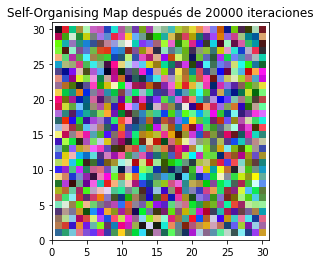

Iteración: 100
Iteración: 200
Iteración: 300
Iteración: 400
Iteración: 500
Iteración: 600
Iteración: 700
Iteración: 800
Iteración: 900
Iteración: 1000
Iteración: 1100
Iteración: 1200
Iteración: 1300
Iteración: 1400
Iteración: 1500
Iteración: 1600
Iteración: 1700
Iteración: 1800
Iteración: 1900
Iteración: 2000
Iteración: 2100
Iteración: 2200
Iteración: 2300
Iteración: 2400
Iteración: 2500
Iteración: 2600
Iteración: 2700
Iteración: 2800
Iteración: 2900
Iteración: 3000
Iteración: 3100
Iteración: 3200
Iteración: 3300
Iteración: 3400
Iteración: 3500
Iteración: 3600
Iteración: 3700
Iteración: 3800
Iteración: 3900
Iteración: 4000
Iteración: 4100
Iteración: 4200
Iteración: 4300
Iteración: 4400
Iteración: 4500
Iteración: 4600
Iteración: 4700
Iteración: 4800
Iteración: 4900
Iteración: 5000
Iteración: 5100
Iteración: 5200
Iteración: 5300
Iteración: 5400
Iteración: 5500
Iteración: 5600
Iteración: 5700
Iteración: 5800
Iteración: 5900
Iteración: 6000
Iteración: 6100
Iteración: 6200
Iteración: 6300
I

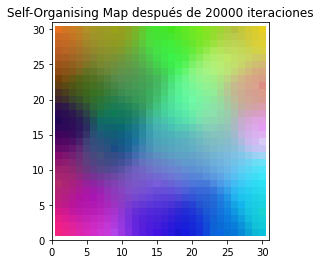

In [25]:
# Entrena la red con el dataset de entrenamiento
pintar_mapa(matriz_pesos)
for iteracion in range(periodo):
    aleatorio=np.random.randint(num_datos)
    
    ValoresEscogidos=datos[aleatorio] # como los datos no se van a modificar no hace falta que pongas el .copy()
 
    bmu,bmu_idx=calcular_bmu(ValoresEscogidos,matriz_pesos,False)

    learning_rate_actual=variacion_learning_rate(learning_rate,iteracion,periodo)
    matriz_pesos[bmu_idx[0]][bmu_idx[1]]+=learning_rate_actual*(ValoresEscogidos-bmu)
    
    vecindario_actual=variacion_vecindario(vecindario,iteracion,periodo)
    
    for x in range(matriz_pesos.shape[0]):
        for x2 in range(matriz_pesos.shape[1]):
            Coordenadas_Neurona=np.array([x, x2])
            distancia =np.sqrt(np.sum((bmu_idx - Coordenadas_Neurona) ** 2))
            if distancia<=vecindario_actual:
                amortiguacion=decay(distancia,vecindario_actual)
                matriz_pesos[x][x2]+= amortiguacion*learning_rate_actual*(ValoresEscogidos-matriz_pesos[x][x2])
              
    
    if (iteracion+1)%100==0: 
        print("Iteración: " + str(iteracion+1))
pintar_mapa(matriz_pesos)

## SOM Clasificación

In [26]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada
def clasificacion(datos,num_datos):
    Mapa_Clasificacion =np.zeros(matriz_pesos.shape) #guarda en cada neurona el último patrón clasificado.
    Mapa_Activacion =np.zeros((lado_mapa,lado_mapa)) #guarda el número de patrones reconocido por cada neurona
    Mapa_Distancias =np.zeros((lado_mapa,lado_mapa)) #guarda la distancia media de todos los patrones de la clase con su vector de pesos





    Distancia_Media=0.0
    Error_Topologico=0.0
    capas=0
    for iteracion in range(num_datos):
        ValoresEscogidos=datos[iteracion]
        bmu_idx2,bmu_idx=calcular_bmu(ValoresEscogidos,matriz_pesos,True) 
        #########################################
        #distancia media (Error de Cuantificación)
        #########################################
        distancia =np.sqrt(np.sum((matriz_pesos[bmu_idx[0]][bmu_idx[1]] - ValoresEscogidos) ** 2))
        Distancia_Media+=abs(distancia)

        #########################################
        #Error topológico
        #########################################    
        Segunda_BMU=np.array([bmu_idx2[0], bmu_idx2[1]]) # lo tranfromamos en un numpy array, para poder restar
        Distancia_Neuronas_Adyacentes= np.sqrt(np.sum((bmu_idx - Segunda_BMU) ** 2))
        if Distancia_Neuronas_Adyacentes>1.5:#las que esta encima y a los lados su distancia es 1, las que estan en diagonal
            Error_Topologico+=1   #su distancia es de 1.41, por eso ponemos > 1.5 para que nos coga todas menos esas


        ###############MAPAS############
        Mapa_Clasificacion[bmu_idx[0]][bmu_idx[1]]=ValoresEscogidos
        if Mapa_Activacion[bmu_idx[0]][bmu_idx[1]] >0: #si ya hay un valor en este neurona hacemos la media, entre el valor antiguo y nuevo
            Mapa_Distancias[bmu_idx[0]][bmu_idx[1]] = (Mapa_Distancias[bmu_idx[0]][bmu_idx[1]] + distancia) /2
        else:
            capas+=1
            Mapa_Distancias[bmu_idx[0]][bmu_idx[1]]=distancia

        Mapa_Activacion[bmu_idx[0]][bmu_idx[1]]+=1 #indicamos que ha esta neurona ha sido reconocida por el patron

    Distancia_Media/=num_datos
    Error_Topologico/=num_datos
    print("Error de Cuantificación: "+ str(Distancia_Media))
    print("Error Topológico: "+ str(Error_Topologico))
    print("Capas: "+ str(capas))
    print("\nMapa de Clasificación: ")
    pintar_mapa(Mapa_Clasificacion)
    print("Mapa de Activación: ")
    histograma3D(Mapa_Activacion)
    print("\n\nMapa de Distancias:\n\n"+ str(Mapa_Distancias))

Error de Cuantificación: 0.04894124627060484
Error Topológico: 0.07
Capas: 96

Mapa de Clasificación: 


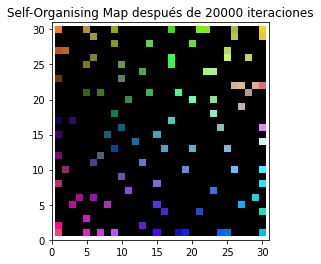

Mapa de Activación: 


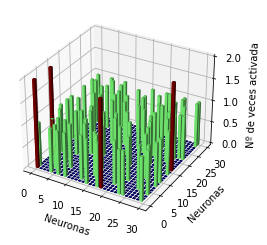



Mapa de Distancias:

[[0.06344973 0.10788306 0.         0.         0.         0.
  0.         0.0370743  0.         0.         0.         0.05019955
  0.         0.         0.0326989  0.         0.0853315  0.
  0.         0.         0.         0.         0.05885368 0.
  0.         0.         0.04105188 0.         0.         0.09161637]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.03013414 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.0216665  0.         0.         0.        ]
 [0.         0.         0.         0.         0.03509761 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.01211588 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.     

In [27]:
clasificacion(datos,num_datos)

## SOM Prueba

Error de Cuantificación: 0.29400652195574756
Error Topológico: 0.25
Capas: 8

Mapa de Clasificación: 


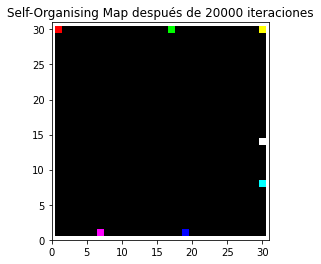

Mapa de Activación: 


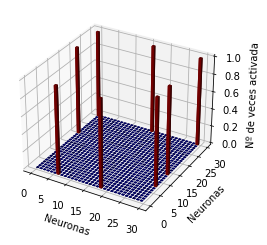



Mapa de Distancias:

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.34046652 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.47691548]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.  

In [28]:
# Clasifica nuevos patrones
Dataset_prueba=np.array([[255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0]])
Num_Datos_prueba=Dataset_prueba.shape[0]

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    Dataset_prueba = Dataset_prueba/ (valor_max-1) # pasamos los valores de 0-255 a 0-1
    
clasificacion(Dataset_prueba,Num_Datos_prueba)